<a href="https://colab.research.google.com/github/nosovdmitry007/Filtr_foto/blob/main/FIlter_best_photo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ФИЛЬТР УДАЧНЫХ ФОТОГРАФИЙ

  Необходимо отсортировать фотографии, т.е. классифицировать  изображения по качеству (удачные фотографии).


Будем расмаирмваить фотографии в формате RAW

Для начала определимся по каким критериям будем сортировать фотографии.

1. фотография пересвечена 30 шт.
2. фотография очень темная 30 шт.
3. фотография смазана 30 шт.
4. фотография без фокуса 30 шт.
5. Сильные шумы (делаем программно 30 шт.)
6. Искажение геометрии 30 шт. 
7. полосы от ламп, Мерцание 30 шт.
8. Удачные фотографии 60 шт.

https://drive.google.com/drive/folders/1ktqIOC_O9tj7Z3wJ4E6xYaPc9epmBWC0?usp=sharing

Все фотографии после загрузки будем поворачивать для получения более полной базы.
в итоге получится база из 97200 элементов (фотографий)

In [ ]:
!pip install rawpy;

     |████████████████████████████████| 1.7 MB 3.6 MB/s 


In [ ]:
import rawpy
import imageio
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import os #Работа с папками и файлами
import cv2
from tensorflow.keras import utils #Утилиты для to_categorical
from matplotlib import pyplot as plt
import random #Для генерации случайных чисел
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential #Сеть прямого распространения
import keras
import time
import datetime
import sys

#Парсинг данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Создаём модуль для добавления шума
def noisy(lo):
  #L=Image.open('thumb.jpeg')

  z=image.img_to_array(lo)
  d = np.array(z/255, dtype=float)
  noise = np.random.normal(0, 0.001 ** 0.5, d.shape)
  out = d + noise
  if out.min() < 0:
      low_clip = -1.
  else:
      low_clip = 0.
  out = np.clip(out, low_clip, 1.0)
  out = np.uint8(out*255)

  im = Image.fromarray(out, 'RGB')

  im.save("thumb1.jpeg")
  z=Image.open('thumb1.jpeg')
  z
  return z
   

In [ ]:

#Создаём классы по которым будем класифицировать фотографии
className=['Fokus','Geometriy','Horoshie_foto','Miganie','Peresvet','Smazany','Temniy','shum']

In [ ]:
#Размер изображения для НС
visota=50
shirina=50
sloi=3

In [ ]:
x_test = [] 
y_test =[]
x_train =[] 
y_train =[] 

#будем делить вю выборку на обучающую и тестовую в соотношении 90% к 10%
#также сразу будет поворачивать фотографии и добавлять шума в класс шум
#решепим фотографии до размера 50*59, иначе не хватает ОЗУ
clas=-1
for i in className: #Проходим по каждому классу
  print(i)
  Fil=len(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)) )
  T=0
  clas+=1
  for j in tqdm(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)),colour = 'green',ncols =100):
      T+=1
      with rawpy.imread('/content/drive/MyDrive/Диплом/'+str(i)+'/' + j) as raw:
          #rgb = raw.postprocess()
          thumb = raw.extract_thumb()
      if thumb.format == rawpy.ThumbFormat.JPEG:
        with open('thumb.jpeg', 'wb') as f:
          f.write(thumb.data)
      elif thumb.format == rawpy.ThumbFormat.BITMAP:
        imageio.imsave('thumb.jpeg', thumb.data)
        
      L=Image.open('thumb.jpeg')
      if i == 'shum':
        L=noisy(L) #Добавляем еще шума в категорию шум

        
      z = L.resize((visota, shirina))

      for k in range(360): #поворачиваем фотогравии на 360 градусов по 1 градусу с сохранением размеров.
        o =z.rotate(k)
        x = image.img_to_array(o)
        x=x.reshape(visota, shirina,sloi) 
        x /= 255
        if T<=Fil*0.9: #делим выборку на тренировочную и тестовую 
          x_train.append(x) #добавляем в обучающую выборку
          y_train.append(clas)
        else:
          x_test.append(x) #добавляем в обучающую выборку
          y_test.append(clas)

  print()

Fokus


100%|███████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.24s/it]



Geometriy


100%|███████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.25s/it]



Horoshie_foto


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.25s/it]



Miganie


100%|███████████████████████████████████████████████████████████████| 30/30 [00:38<00:00,  1.28s/it]



Peresvet


100%|███████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.24s/it]



Smazany


100%|███████████████████████████████████████████████████████████████| 30/30 [00:32<00:00,  1.10s/it]



Temniy


100%|███████████████████████████████████████████████████████████████| 30/30 [00:33<00:00,  1.13s/it]



shum


100%|███████████████████████████████████████████████████████████████| 30/30 [00:47<00:00,  1.58s/it]

In [ ]:
#Преобразуем в нампай массив
x_test = np.array(x_test)  
y_test =np.array(y_test) 
x_train =np.array(x_train) 
y_train =np.array(y_train)

In [ ]:
x_train.shape

(87480, 50, 50, 3)

In [ ]:
x_test.shape

(9720, 50, 50, 3)

In [ ]:
y_train

array([0, 0, 0, ..., 7, 7, 7])

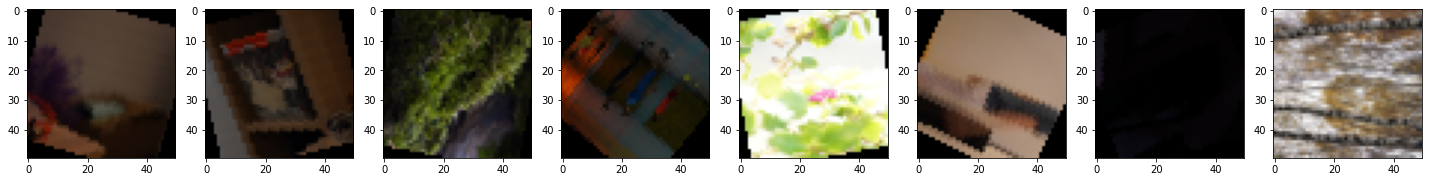

In [ ]:
#Выводим для примера картинки по каждому классу
 
fig, axs = plt.subplots(1, 8, figsize=(25, 3)) #Создаем полотно из 8 графиков
z=-1
for i in range(8): #Проходим по классам от 0 до 7
  z+=1
  label_indexes = np.where(y_train==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = x_train[index] #Выбираем из x_train нужное изображение

  axs[i].imshow(Image.fromarray((img * 255).astype(np.uint8))) #Отображаем изображение i-ым графиков
  
plt.show() #Показываем изображения

In [ ]:
y_train = utils.to_categorical(y_train, 8) 
y_test = utils.to_categorical(y_test, 8)

In [ ]:
#Выводим размкрности всех выборок для обучения НС
#Обучающая выборка
print(x_train.shape)
print(y_train.shape)
#Тестовая выборка
print(x_test.shape)
print(y_test.shape)

(87480, 50, 50, 3)
(87480, 8)
(9720, 50, 50, 3)
(9720, 8)


#Нейросеть

In [ ]:
#задаём batch_size
batch_size = 128
 
#Создаем последовательную модель
model = Sequential()
#Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(visota, shirina,sloi)))
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
 
#Слой пакетной нормализации
model.add(BatchNormalization())
#Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
 
#Слой пакетной нормализации
model.add(BatchNormalization())
#Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
 
#Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
#Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Выходной полносвязный слой
model.add(Dense(8, activation='softmax'))

In [ ]:
#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
#архитектурв НС
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 50, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       1

Epoch 1/10
684/684 [==============================] - 77s 67ms/step - loss: 0.2849 - accuracy: 0.8973 - val_loss: 0.2573 - val_accuracy: 0.9068
Epoch 2/10
684/684 [==============================] - 45s 65ms/step - loss: 0.0558 - accuracy: 0.9813 - val_loss: 1.0088 - val_accuracy: 0.8860
Epoch 3/10
684/684 [==============================] - 45s 66ms/step - loss: 0.0277 - accuracy: 0.9917 - val_loss: 0.2926 - val_accuracy: 0.9082
Epoch 4/10
684/684 [==============================] - 45s 66ms/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.4911 - val_accuracy: 0.9156
Epoch 5/10
684/684 [==============================] - 45s 66ms/step - loss: 0.0353 - accuracy: 0.9902 - val_loss: 0.2948 - val_accuracy: 0.9219
Epoch 6/10
684/684 [==============================] - 45s 66ms/step - loss: 0.0244 - accuracy: 0.9947 - val_loss: 1.2228 - val_accuracy: 0.8749
Epoch 7/10
684/684 [==============================] - 45s 66ms/step - loss: 0.0207 - accuracy: 0.9946 - val_loss: 1.5786 - val_accuracy:

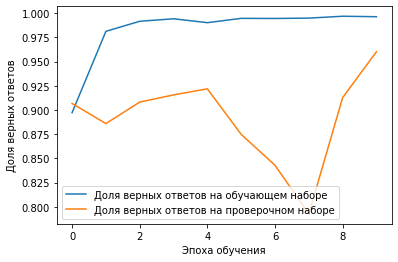

In [ ]:
#Обучаем сеть
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_test, y_test),
                    verbose=1)
 
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Вывод

Точность нейросети очень хорошая достигает 96% на 10 эпохе из 10.


В дальнейшем планирую написать колбек для сохранения модели с наилучшим результатом и протестировать ее на фотографиях которых не было в выборке.

#Пишем свой Callback, для сохранения модели.

In [ ]:
 
 
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Прекратите тренироваться, когда убыток достигнет своего минимума, т. е. убыток перестанет уменьшаться.
 
  Аргументы:
      терпение: Количество эпох, которые нужно подождать после того, как будет пройдена минута. После этого
      количество улучшений отсутствует, тренировки прекращаются.
  """
 
    def __init__(self, patience=10):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights для хранения весов, при которых происходит минимальная потеря.
 
 
    def on_train_begin(self, logs=None):
        # Количество эпох, которое он ждал, когда потери больше не будут минимальными.
        self.wait = 0
        # Эпоха, на которой заканчивается обучение.
        self.stopped_epoch = 0
        # Инициализируйте лучшее как бесконечность.
        self.best = 0#np.Inf
 
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_accuracy')
        if np.less(self.best, current):
            self.best = current
            self.wait = 0
            # Запишите лучшие веса, если текущие результаты лучше (меньше).
            self.best_weights = self.model.get_weights()
            #сохраняем модель
 
            model.save('best_model_'+str(round(logs.get('val_accuracy')*100,2))+'.h5')
            print('  Сохранена модель  на эпохе: ' ,epoch, 'с точностью: ', str(round(logs.get('val_accuracy')*100,2)),'%')
        else:
          self.wait += 1
          if self.wait >= self.patience:
              
              self.stopped_epoch = epoch
              self.model.stop_training = False
              print("  Восстановление весов моделей с конца лучшей эпохи.")
              self.model.set_weights(self.best_weights)
              self.wait=0

необходимо достичь точность 98-99%

Epoch 1/100
684/684 [==============================] - 45s 66ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.4428 - val_accuracy: 0.9271
Epoch 2/100
684/684 [==============================] - 45s 65ms/step - loss: 0.0128 - accuracy: 0.9979 - val_loss: 1.4080 - val_accuracy: 0.8173
Epoch 3/100
684/684 [==============================] - 45s 66ms/step - loss: 0.0075 - accuracy: 0.9986 - val_loss: 0.1820 - val_accuracy: 0.9580
Epoch 4/100
684/684 [==============================] - 45s 65ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.3824 - val_accuracy: 0.9434
Epoch 5/100
684/684 [==============================] - 45s 65ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.3869 - val_accuracy: 0.9509
Epoch 6/100
684/684 [==============================] - 45s 66ms/step - loss: 0.0187 - accuracy: 0.9973 - val_loss: 0.2107 - val_accuracy: 0.9626
Epoch 7/100
684/684 [==============================] - 45s 65ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0437 - val_ac

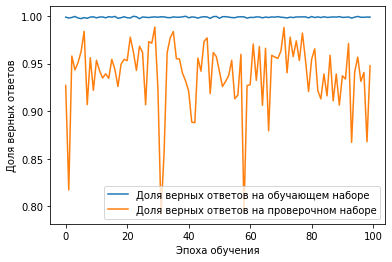

In [ ]:
#Обучаем сеть
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=100,
                    validation_data=(x_test, y_test),
                    verbose=1,callbacks=[EarlyStoppingAtMinLoss()])
 
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Проверяем точность модели

Загрузим по 1 фотографии из каждего класса случайным образом и отобразим их по вертикальной оси  зеркально.

In [ ]:
xTest = [] 
yTest =[]


#будем делить вю выборку на обучающую и тестовую в соотношении 90% к 10%
#также сразу будет поворачивать фотографии и добавлять шума в класс шум
#решепим фотографии до размера 50*59, иначе не хватает ОЗУ
clas=-1
for i in className: #Проходим по каждому классу
  Fil=len(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)) )
  clas+=1
  K=0
  K= random.choice(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)))
  #for j in tqdm(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)),colour = 'green',ncols =100):
 
  with rawpy.imread('/content/drive/MyDrive/Диплом/'+str(i)+'/' + K) as raw:
      
      thumb = raw.extract_thumb()
  if thumb.format == rawpy.ThumbFormat.JPEG:
    with open('thumb2.jpeg', 'wb') as f:
      f.write(thumb.data)
  elif thumb.format == rawpy.ThumbFormat.BITMAP:
    imageio.imsave('thumb2.jpeg', thumb.data)
    
  L=Image.open('thumb2.jpeg')
  L=L.transpose(Image.FLIP_LEFT_RIGHT)
  if i == 'shum':
    L=noisy(L) #Добавляем еще шума в категорию шум

  z = L.resize((visota, shirina))
  x = image.img_to_array(z)
  x=x.reshape(visota, shirina,sloi) 
  x /= 255
  xTest.append(x) #добавляем в обучающую выборку
  yTest.append(clas)


xTest = np.array(xTest)  
yTest =np.array(yTest)


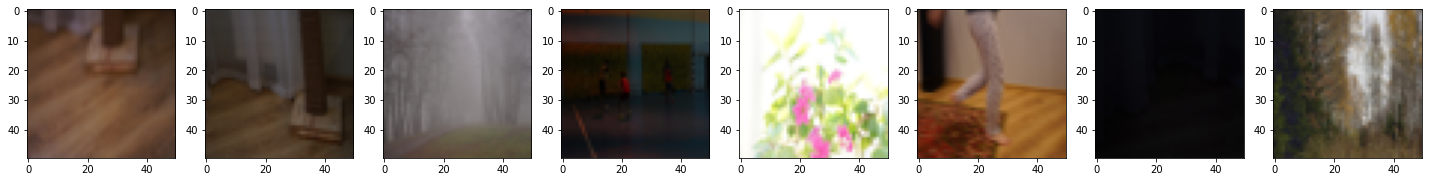

In [ ]:
#Выводим для примера картинки по каждому классу
 
fig, axs = plt.subplots(1, 8, figsize=(25, 3)) #Создаем полотно из 8 графиков
z=-1
for i in range(8): #Проходим по классам от 0 до 7
  z+=1
 # label_indexes = np.where(yTest==i)[0] #Получаем список из индексов положений класса i в y_train
 # index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = xTest[z] #Выбираем из x_train нужное изображение

  axs[i].imshow(Image.fromarray((img * 255).astype(np.uint8))) #Отображаем изображение i-ым графиков
  
plt.show() #Показываем изображения

In [ ]:
yTest = utils.to_categorical(yTest, 8) 


Загружаем модель с наилучшей вероятностью класификации

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('best_model_98.85.h5', compile = False)

In [ ]:
prediction = model1.predict(xTest) #Классифицируем каждое изображение
for i in range(8): #Проходим по картинкам
  #Вводим результаты на экран
  print("Распознанный образ:", className[np.argmax(prediction[i])], '. Верный ответ', className[i])

Распознанный образ: Fokus . Верный ответ Fokus
Распознанный образ: Geometriy . Верный ответ Geometriy
Распознанный образ: Horoshie_foto . Верный ответ Horoshie_foto
Распознанный образ: Miganie . Верный ответ Miganie
Распознанный образ: Peresvet . Верный ответ Peresvet
Распознанный образ: Smazany . Верный ответ Smazany
Распознанный образ: Temniy . Верный ответ Temniy
Распознанный образ: shum . Верный ответ shum


Видим результты предсказаания совпадают с реальными классами